<a href="https://colab.research.google.com/github/tsakailab/DiffProg/blob/main/MLPrimerDiffProg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 微分可能プログラミングで始める機械学習
Machine Learning Primer: Exploring Differentiable Programming

酒井 智弥

## はじめに

[機械学習（machine learning）](https://ja.wikipedia.org/wiki/Category:%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92)の目的は，データから正確な予測を計算する機械を作ることです．特に大規模な[深層学習](https://ja.wikipedia.org/wiki/%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0)は，画像や音声の認識，自然言語処理，自動運転など，様々な分野で非常に高度な人工知能を実現する中心的な技術になっています．正確な予測を達成するためには，予測に役立つデータの特徴を捉えられるように計算の仕組みを最適化する必要があります．[微分可能プログラミング（differentiable programming）](https://en.wikipedia.org/wiki/Differentiable_programming)は，[勾配（gradient）](https://ja.wikipedia.org/wiki/%E5%8B%BE%E9%85%8D_(%E3%83%99%E3%82%AF%E3%83%88%E3%83%AB%E8%A7%A3%E6%9E%90))を自動的に計算して複雑な予測の仕組みを最適化することを可能にします．本稿では，今日的な機械学習の手引きとして微分可能プログラミングの基本的な機能を紹介します．なお，このJupyter Notebookは[「はじめての精密工学」89巻09号（2023年9月）に掲載された記事](https://doi.org/10.2493/jjspe.89.695)に基づいており，Google Colaboratoryで実行できます．

## モデルの設計と学習

機械学習のモデルとは，与えられた入力に対して適切な予測を出力する関数です．人工知能を実現しているニューラルネットワークも，入力から予測値を計算する関数に過ぎません．出力の予測値は入力 $\vec x$ の関数 $f(\vec x)$ です．いくつか複数の数値をまとめてひとつの入力として扱いたいことがあるので，$\vec x$ は $m_\mathrm{in}$ 次元ベクトルとします．

関数としてモデルを設計しましょう．一次関数は，比較的単純で，しかも応用の範囲が広いモデルです．
$$ f(\vec x)=\vec w\cdot\vec x+b = w_1 x_1+w_2 x_2+\cdots+w_{m_\mathrm{in}}x_{m_\mathrm{in}}+b\qquad(1)$$
$\vec w$ と $b$ はそれぞれ「重み（weight）」と「バイアス（bias）」と呼ばれるモデル変数（model parameters）です．$f(\vec x)$ が正確な予測値を出力するためには， $\vec w$ と $b$ を適切な値に調整しておく必要があります．

[PyTorch](https://pytorch.org/)は深層学習で最も人気のあるフレームワークのひとつであり，微分可能プログラミングの入門者にもお勧めです．
PyTorchを使って式(1)の関数を実装する一例を示します．

In [ ]:
def model(x):
    return x.matmul(w.t()) + b

$m_\mathrm{in}=1$ のとき（$x=x_1$） ，方程式 $y=f(x)$ は傾き $w_1$，$y$ 切片 $b$ の直線を表します．例えば，バネにおもりをつるすと，バネはおもりの質量に比例した長さだけ伸びます．自然長を加えたバネ全体の長さ $y$ は，質量 $x$ の一次関数 $f(x)=w_1x+b$ で予測できます．これがバネ長のモデルです．

あとは，$w_1$ と $b$ の値が決まればモデルの完成です．実際におもりをつるして調べたデータと合うように決めましょう．質量 `x` を変えながら長さ `y` を6通り測りました．6個の1次元データを，サイズ `[6,1]` の [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) 型で表します．

In [ ]:
import torch
x = torch.tensor([[0.1, 0.3, 0.5, 0.7, 0.8, 1.0]]).T
y = torch.tensor([[0.8, 1.4, 2.0, 1.6, 2.9, 3.5]]).T
print(type(x), x.shape)
#w, b = torch.tensor([[3.0]]), 0.5; print(model(x)); print(y)

<class 'torch.Tensor'> torch.Size([6, 1])


 質量0.7のときのバネ長1.6は測定の間違いでしょうか．何にせよ，このデータから傾き $w_1$ と切片 $b$ を推定できそうです．直線を当てはめる[最小二乗法](https://ja.wikipedia.org/wiki/%E6%9C%80%E5%B0%8F%E4%BA%8C%E4%B9%97%E6%B3%95)をご存じの方は，公式を使って確認してください．

 ここでは，微分可能プログラミングの真価が発揮されるPyTorchの最適化機能を使うことにします．まず，モデル $f(\vec x)$ による予測値の誤差の総和を[損失関数（loss function）](https://ja.wikipedia.org/wiki/%E6%90%8D%E5%A4%B1%E9%96%A2%E6%95%B0#:~:text=%E6%95%B0%E7%90%86%E6%9C%80%E9%81%A9%E5%8C%96%E3%81%8A%E3%82%88%E3%81%B3%E6%B1%BA%E5%AE%9A,%E5%AE%9F%E6%95%B0%E3%81%AB%E5%AF%BE%E5%BF%9C%E3%81%A5%E3%81%91%E3%82%8B%E9%96%A2%E6%95%B0)として定義します．最小二乗法では平均二乗誤差が使われますが，ここでは，予測値 `f` と実測値 `y` の差の絶対値の和を損失関数とします．

In [ ]:
def loss(f, y):
    return torch.abs(f-y).sum()

推定したい $m_\mathrm{in}$ 次元ベクトル $\vec w$ と実数 $b$ を，Tensor型の変数 `w` と `b` とし，初期値を適当な乱数にしておきます．損失関数が小さくなるように勾配を使って `w` と `b` の値を修正したいので，[`requires_grad=True`](https://pytorch.org/docs/master/autograd.html#torch.Tensor.requires_grad) に設定します．

In [ ]:
m_in, m_o = 1, 1
w = torch.rand(m_o, m_in, requires_grad=True)
b = torch.rand(m_o, requires_grad=True)

`w` と `b` を修正する最適化のアルゴリズムには [`torch.optim.Adam`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)を採用します．`lr` は[学習率（learning rate）](https://en.wikipedia.org/wiki/Learning_rate)と呼ばれ，修正する大きさの目安です．小さすぎると収束までに時間がかかり，大きすぎると損失関数が小さくならずに発散します．

In [ ]:
optimizer = torch.optim.Adam([w, b], lr=0.01)

それでは，`w` と `b` の修正を1000回繰り返してみましょう．予測値 `model(x)` と実測値 `y` から算出した損失を `l` とします．[`optimizer.zero_grad()`](https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch) で勾配をゼロに初期化してから，[`l.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) を実行して損失関数の勾配を計算し，[`optimizer.step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) で `w` と `b` を修正します．

In [ ]:
for epoch in range(1001):
    l = loss(model(x), y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss =", l.item())
print("w =", w, "\nb =", b)

epoch = 0 , loss = 4.16153621673584
epoch = 200 , loss = 1.6144306659698486
epoch = 400 , loss = 1.0179314613342285
epoch = 600 , loss = 1.0137557983398438
epoch = 800 , loss = 1.0036345720291138
epoch = 1000 , loss = 1.0008022785186768
w = tensor([[2.9994]], requires_grad=True) 
b = tensor([0.4993], requires_grad=True)


損失が約1まで小さくできています．傾きと切片はそれぞれ約3と0.5と推定されました．グラフで確認しましょう．質量0.7のときのバネ長は，1.6ではなく2.6だったようですね．

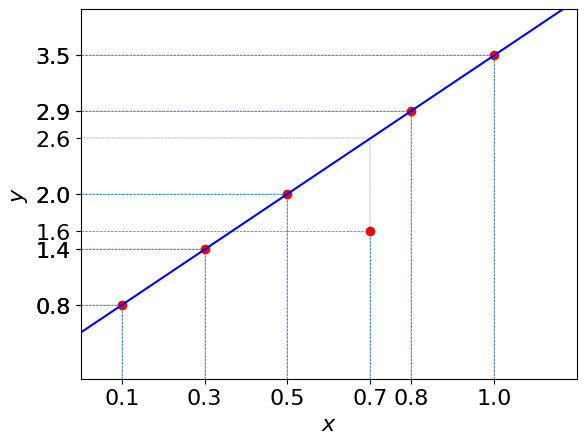

In [ ]:
#@title 図1　誤差の絶対値和の最小化による線形回帰の例．<br>回帰直線とデータを図示します．
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

plt.vlines(x, 0, y, linestyle="dashed", linewidths=0.5)
plt.hlines(y, 0, x, linestyle="dashed", linewidths=0.5)
xs = torch.linspace(0.0, 1.2, 20)
with torch.no_grad():
    y_pred = model(x)[:,0].round(decimals=1)
    plt.vlines(x, 0, y_pred, linestyle="dashed", linewidths=0.2, colors='k')
    plt.hlines(y_pred, 0, x, linestyle="dashed", linewidths=0.2, colors='k')
    ys = model(xs.unsqueeze(1))
plt.plot(xs, ys, "b")
plt.scatter(x, y,c="red")

plt.xticks(x[:,0]); plt.yticks(list(set(list(y_pred)+list(y[:,0]))));
plt.xlim([0,1.2]); plt.ylim([0, 4]);
plt.xlabel("$x$"); plt.ylabel("$y$");
plt.rcParams.update({'font.size': 10})

以上のように，モデル（model）と損失（loss）を実装すれば，モデル変数を最適化するアルゴリズムを自作しなくても，[Adam](https://arxiv.org/abs/1412.6980) など[勾配に基づく最適化のアルゴリズム](https://pytorch.org/docs/stable/optim.html#algorithms)を適用できるようになります．上記の例では，最小解において[誤差の絶対値](https://en.wikipedia.org/wiki/Proximal_gradient_method)が微分不可能なので，厳密には[線形計画法](https://ja.wikipedia.org/wiki/%E7%B7%9A%E5%9E%8B%E8%A8%88%E7%94%BB%E6%B3%95)か[近接写像に基づくアルゴリズム](https://en.wikipedia.org/wiki/Proximal_gradient_method)を使うべきです．しかし，Adamでも近似解が得られました．



## 自動微分の仕組み

微分可能プログラミングは，導関数を正確に数値計算する技術です．微分可能な関数が組み合わさった複雑な合成関数でも，その導関数の値（微分係数）が合成関数の微分公式に従って自動的に計算されます．この仕組みは[自動微分（automatic differentiation）](https://ja.wikipedia.org/wiki/%E8%87%AA%E5%8B%95%E5%BE%AE%E5%88%86)として知られており，計算グラフ（computational graph）と呼ばれる計算の表現が基盤になっています（[参考](https://jmlr.org/papers/volume18/17-468/17-468.pdf)）．

一次関数を $f=wx+b$ のように計算し，$y$ と比べた二乗誤差を $l=(f-y)^2$ と計算するとします．$w=3.0$，$b=0.5$ のとき，$x=0.7$，$y=1.6$ から二乗誤差を計算する過程は，下図のように表せます．このようなデータの流れと演算の表現を計算グラフ（computational graph）といいます．

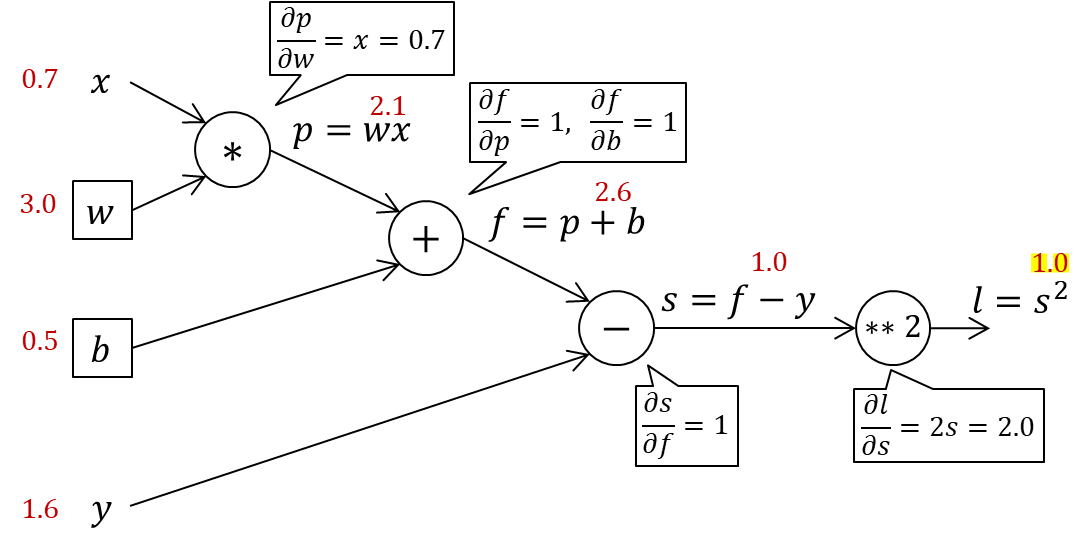

図2　$l=((wx+b)+y)^2$ を表す計算グラフ．

図の左から右に計算が進み，$l=1.0$ が算出されます．この計算過程を前向き計算（forward computation または forward pass）と呼びます．計算グラフの節 "$*$"，"$+$"，"$-$"，"$**2$" はそれぞれ，積，和，差，二乗の演算を表します．微分可能プログラミングに使われる演算や関数は，前向き計算だけでなく，偏導関数を計算する機能も内蔵しています．例えば，二乗の演算 "**2" は，入力された $s$ から $s^2$ を算出するだけでなく，図中の吹き出しに示すように，偏導関数 $2s$ を計算する機能を備えています．この機能を組み合わせて，合成微分を実現します．
具体的には，まず，前向き計算をしながら計算グラフを組み立てます．このとき，図中の吹き出しに示す導関数も計算し，グラフの各節に値をすべて記憶しておきます．前向き計算終了後，計算グラフをたどりながら計算済みの偏導関数を次々に乗じることで，合成微分を計算できます．

この方法で勾配を計算する過程は逆伝播（backward propagation）と呼ばれます．通称，バックプロップ（backpropagation）です．
例えば，損失 $l$ を $w$ と $b$ の関数と見なし，損失関数の勾配 $\nabla l=[\partial l/\partial w,\partial l/\partial b]$ を計算できます．合成関数の偏導関数を計算する連鎖律（chain rule）から次式が成り立ちます．
$$\frac{\partial l}{\partial w}=\frac{\partial l}{\partial s}\frac{\partial s}{\partial f}\frac{\partial f}{\partial p}\frac{\partial p}{\partial w}=2.0\cdot 1\cdot 1\cdot 0.7=1.4$$
$$\frac{\partial l}{\partial b}=\frac{\partial l}{\partial s}\frac{\partial s}{\partial f}\frac{\partial f}{\partial b}=2.0\cdot 1\cdot 1=2.0$$
出力 $l$ から $w$ または $b$ までの経路に沿って，節に記憶されている導関数の値を乗じることで勾配が計算できていることを確認してください．

PyTorchにもバックプロップを計算する機能が備わっています．

In [ ]:
w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
f = w * x[3] + b
l = (f - y[3])**2

l.backward()
print(w.grad, b.grad)

tensor(1.4000) tensor(2.0000)


偏微分係数が得られていますね．`l.backward()` は `requires_grad=True` を設定した計算グラフの葉（leaf）に関する `l` の偏微分係数を計算します．替わりに `torch.autograd.grad(l, [w, b])` と書くと，指定した `[w, b]` に関する勾配が得られます（[参考](https://pytorch.org/blog/how-computational-graphs-are-executed-in-pytorch/)）．

In [ ]:
w = torch.tensor(3.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

f = w * x[3] + b
l = (f - y[3])**2
print(l)

#print(torch.autograd.grad(l, [f, w, b]))
dl = torch.autograd.grad(l, [w, b])
print(dl)

tensor([1.0000], grad_fn=<PowBackward0>)
(tensor(1.4000), tensor(2.0000))


微分可能プログラミングで実現されているものは，計算グラフに基づく自動微分です．PyTorchや現在のTensorFlowは，計算グラフを意識しなくても，書かれた式の手順に従って前向き計算を進めながら計算グラフを構築します．これを[define-by-run](https://www.nvidia.com/en-us/glossary/data-science/pytorch/)といいます．合成関数の微分公式に従って導関数が正確に計算されるので，微小な $\varepsilon$ で変化率 $(l(w+\varepsilon,b)-l(w,b))/\varepsilon$ を近似計算する[数値微分](https://en.wikipedia.org/wiki/Numerical_differentiation)とは異なります．

## 人工ニューラルネットワーク
[`torch.nn`](https://pytorch.org/docs/stable/nn.html)は，多層のニューラルネットワークを構成するための部品や損失関数等を多数提供しています．モデル変数は最適化しやすい初期値に設定されています．式(1)の一次関数モデルを $m_\mathrm{o}$ 個集めると，$m_\mathrm{in}$ 入力 $m_\mathrm{o}$ 出力の[全結合層（fully-connected layer; fc）](https://en.wikipedia.org/wiki/Convolutional_neural_network#Fully_connected_layers)になり，[`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) を用いて定義できます．平均二乗誤差を測る損失関数は [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)，差の絶対値の平均は [`nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) です．


In [ ]:
import torch.nn as nn
model = nn.Linear(in_features=m_in, out_features=m_o)
loss = nn.L1Loss()  # nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1001):
    l = loss(model(x), y)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

print("w =", model.weight.detach(), "\nb = ", model.bias.detach())

epoch = 0 , loss =  1.4275994300842285
epoch = 200 , loss =  0.4657668173313141
epoch = 400 , loss =  0.2547534704208374
epoch = 600 , loss =  0.16747236251831055
epoch = 800 , loss =  0.16862905025482178
epoch = 1000 , loss =  0.1693596988916397
w = tensor([[2.9991]]) 
b =  tensor([0.5025])


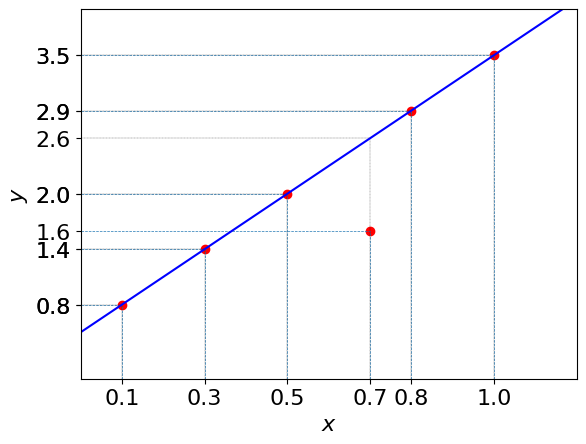

In [ ]:
#@title 図1'　`torch.nn` モジュールを用いた線形回帰の例．<br>誤差の絶対値の平均 `L1Loss` を用いると，図1と同じ回帰直線が得られます．
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

plt.vlines(x, 0, y, linestyle="dashed", linewidths=0.5)
plt.hlines(y, 0, x, linestyle="dashed", linewidths=0.5)
xs = torch.linspace(0.0, 1.2, 20)
with torch.no_grad():
    y_pred = model(x)[:,0].round(decimals=1)
    plt.vlines(x, 0, y_pred, linestyle="dashed", linewidths=0.2, colors='k')
    plt.hlines(y_pred, 0, x, linestyle="dashed", linewidths=0.2, colors='k')
    ys = model(xs.unsqueeze(1))
plt.plot(xs, ys, "b")
plt.scatter(x, y,c="red")

plt.xticks(x[:,0]); plt.yticks(list(set(list(y_pred)+list(y[:,0]))));
plt.xlim([0,1.2]); plt.ylim([0, 4]);
plt.xlabel("$x$"); plt.ylabel("$y$");
plt.rcParams.update({'font.size': 10})

[`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) を使うと，数珠繋ぎの多層構造をもつモデルを簡単に作れます．例えば，$m_\mathrm{h}$ 次元の中間層をもつ $m_\mathrm{in}=2$ 入力 $m_\mathrm{o}=1$ 出力の3層ニューラルネットワークは，
```python
m_in, m_h, m_out = 2, 3, 1
model = nn.Sequential(nn.Linear(m_in, m_h), nn.ReLU(), nn.Linear(m_h, m_o))
```
のように定義できます．[`nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)は，[活性化関数（activation function）](https://en.wikipedia.org/wiki/Activation_function)の一種です．一次関数よりも柔軟な，折れ線や曲線，曲面などを表せる非線形関数のモデルを作りたいときに使われます．

機械学習では，実数値を予測する問題を[回帰（regression）](https://en.wikipedia.org/wiki/Regression_analysis)，種類を予測する問題を[識別（classification）](https://ja.wikipedia.org/wiki/%E5%88%86%E9%A1%9E_(%E7%B5%B1%E8%A8%88%E5%AD%A6))といいます．$m_\mathrm{o}$ 個の実数を予測する回帰では [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) などの損失関数でモデルを学習します．識別問題の場合は，$m_\mathrm{o}$ 個の各種類の可能性を表す確率をモデルに予測させるため，学習には[交差エントロピー（cross entropy）](https://en.wikipedia.org/wiki/Cross_entropy)と呼ばれる損失関数 [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) が使われます．[`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) 関数を使うと，$m_\mathrm{o}$ 個のモデルの出力を，合計が1の確率になるように換算できます．もし，検査薬のように陰陽で分類する二値問題ならば，$m_\mathrm{o}=1$ として [`nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) で学習できます．

####例題： [この例と同様の識別器をPyTorchで作ります．](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.27615&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)<br>円状に分布するデータの二値分類を3層のMLPに学習させます．

In [ ]:
m_in, m_h, m_o = 2, 3, 1
torch.manual_seed(1)
model = nn.Sequential(nn.Linear(m_in, m_h),
                      nn.ReLU(),
                      nn.Linear(m_h, m_o))
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
)


In [ ]:
from sklearn.datasets import make_circles
x, y = make_circles(n_samples=150, random_state=0,
                    noise=0.08, factor=0.3)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

loss = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1001):
    l = loss(model(x), y)
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

epoch = 0 , loss =  0.7016927003860474
epoch = 200 , loss =  0.37705692648887634
epoch = 400 , loss =  0.12264726310968399
epoch = 600 , loss =  0.02916298247873783
epoch = 800 , loss =  0.013975828886032104
epoch = 1000 , loss =  0.008583223447203636


<Figure size 640x480 with 0 Axes>

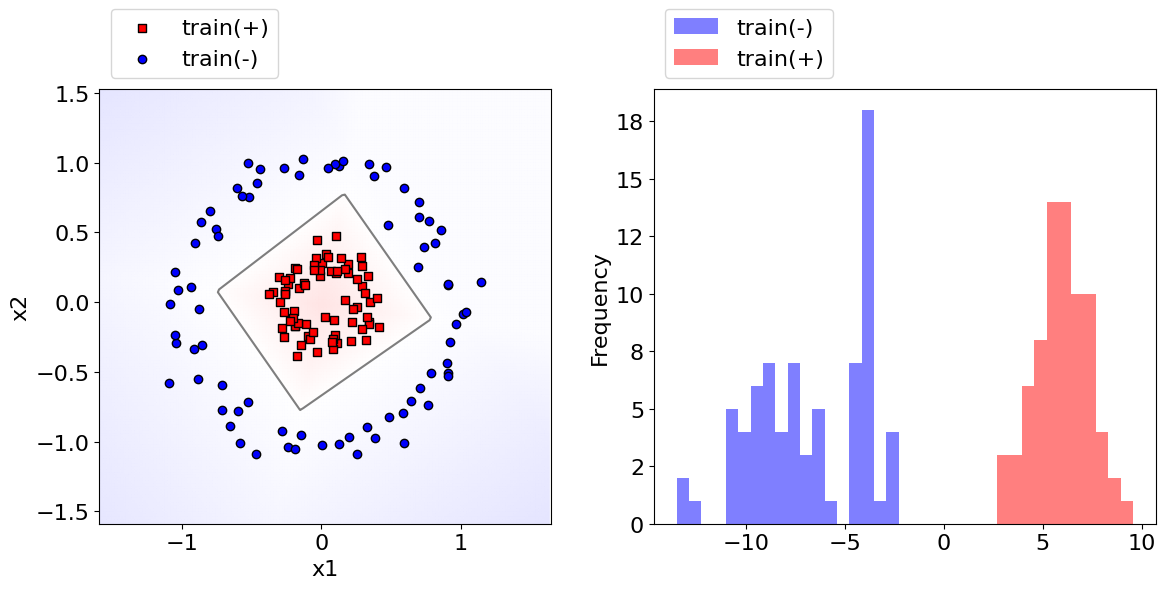

In [ ]:
#@title 図3　3層のMLPによる二値分類の例．<p>このMLPは，2入力1出力の関数です．[中間層の活性化関数ReLUによって，最大で六角形の境界が作られます．](https://www.wolframalpha.com/input?i=plot%28+%28+-1.2*max%281.2x%2B0.35y-0.33%2C+0%29+-+1.3*max%28-0.22x-1.2y-0.61%2C+0%29+-+1.3*max%28-0.93x%2B0.81y-0.58%2C0%29++%29+for+x+from+-6+to+6+for+y+from+-6+to+6%29)　[[出典]](https://datascience.stackexchange.com/questions/76022/what-does-the-descision-boundary-of-a-relu-look-like)．</p>
!wget -q -N https://gist.githubusercontent.com/tsakai-g/1920bc185be0c497579968e00a9b3674/raw/e9716a16ee6a701dad030b6f94195485b3b7cb2c/plot2cls.py
%run plot2cls.py
plot2cls(x.detach(), y.detach().view(-1), lambda x: model(torch.tensor(x, dtype=torch.float32)).detach().view(-1)).plot_clf()

詳細は割愛しますが，データの規模が大きいときは，[`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html}) を使い，小分けにしたデータごとにモデル変数を修正することを反復します．また，学習が終わったモデルは，学習に使っていないデータに対する予測の正しさを調べて評価してください．

全結合層のみの多層ニューラルネットワークは[多層パーセプトロン（multilayer perceptron; MLP）](https://en.wikipedia.org/wiki/Multilayer_perceptron)とも呼ばれます．理論上，3層のMLPは中間層の次元 $m_\mathrm{h}$ を増やすことで，任意の関数 $f:\mathbb{R}^{m_\mathrm{in}}\rightarrow \mathbb{R}^{m_\mathrm{o}}$ を[任意の誤差で近似できます](https://en.wikipedia.org/wiki/Universal_approximation_theorem)．しかし，対象のデータによっては，出力の予測に役立つ特徴量をMLPよりも上手に入力データから算出できるニューラルネットワークが考案されています．

[畳み込みニューラルネットワーク（convolutional neural network; CNN）](https://en.wikipedia.org/wiki/Convolutional_neural_network)は，画像の特徴抽出に適しています．複雑に見える画像でも，局所的には単純な模様が組み合わさっていて，徐々に全体が構成されています．1つの[畳み込み層](https://en.wikipedia.org/wiki/Convolutional_neural_network#Convolutional_layer) [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) では，[フィルタカーネル（filter kernel）](https://en.wikipedia.org/wiki/Kernel_(image_processing))と呼ばれる $C$ 種類の局所的な模様を入力から調べ，それぞれの模様の分布を表す特徴マップ（feature map）を $C$ 枚出力します．$C$ はチャネル数と呼ばれ，数十から数百程度の数に設定します．[バッチ正規化層](https://arxiv.org/abs/1502.03167)[`nn.BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) で特徴マップの強弱を整え，顕著な特徴を選ぶ[活性化関数](https://en.wikipedia.org/wiki/Activation_function)（[ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))など）を間に挟みながら畳み込み層を重ねつつ，途中で数回，[`nn.Maxpool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) などの[プーリング層（pooling layer）](https://en.wikipedia.org/wiki/Convolutional_neural_network#Pooling_layers)で特徴マップを縮小するのが基本的なCNNの構成です．画像認識では，畳み込み層のフィルタカーネルなどを学習可能なモデル変数とし，CNNを最適化します．

モデル変数の多い大きなモデルの学習には，大量の学習データが必要になるため，深層学習は当初，手の届く人が少ない技術でした．しかし，微分可能プログラミング環境の普及とともに，学習済みモデル（pre-trained model）が容易に入手できるようになりました．例えば，PyTorchで使える学習済みモデルが [`torchvision.models`](https://pytorch.org/vision/stable/models.html) や[PyTorch Hub](https://pytorch.org/hub/research-models)から提供されています．また，[Transformer](https://arxiv.org/abs/1706.03762)を基盤にした大規模言語モデルなども[Hugging Face](https://huggingface.co/)から入手可能です．
学習済みモデルを流用したモデルを設計し，自前の学習データで微調整（fine tuning）する[転移学習（transfer learning）](https://en.wikipedia.org/wiki/Transfer_learning)という方法がよく使われます．

以下の例は，`torchvision.models` から学習済みモデル vgg16_bn を入手し，その構成を表示します．[VGG16](https://arxiv.org/abs/1409.1556)は，CNNの層数を増やすことで画像認識をより正確にしようと試みられていた時期の代表的なモデルです．サイズ $3\times 3$ のフィルタカーネルをもつ `Conv2d` を2回または3回重ねることで，サイズ $5\times 5$ または $7\times 7$ 相当のフィルタカーネルをより少ないモデル変数で実現しています．

In [ ]:
import torch
from torchvision import models
# https://pytorch.org/vision/stable/models.html
model = models.vgg16_bn(weights='DEFAULT')
print(model)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 92.1MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

大規模で複雑なモデルでも，PyTorchやTensorFlowを使えば容易に実装でき，Adamなどのオプティマイザで学習できます．もちろん，予測性能の高いモデルを作り上げるためには様々な工夫と試行錯誤が必要になります．モデルは，予測に役立つ特徴量をデータから算出する機構を備え，データの多様性に見合う規模のモデル変数をもつように設計します．予測の誤差の性質を踏まえて損失関数を選択し，極端な局所解に陥らずに収束するようにオプティマイザと学習データを使います．また，学習データに対してだけ予測性能が高くなり過ぎる過学習（overfitting）にも注意が必要です．

## 回帰と逆問題
画像処理を例に，機械学習の分野を超えた微分可能プログラミングの可能性を伝えたいと思います．

100%|██████████| 26421880/26421880 [00:01<00:00, 17622807.81it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 287204.45it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5449711.31it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19452501.79it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



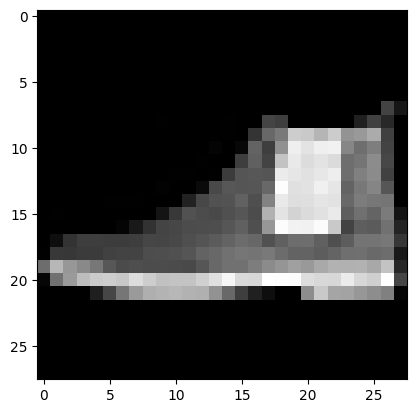

In [ ]:
from torchvision import datasets
# [MNIST](http://yann.lecun.com/exdb/mnist/)
# tvds = datasets.MNIST('./data', download=True, train=True);
# [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)
tvds = datasets.FashionMNIST('./data', download=True, train=True);

# [Kuzushiji-MNIST](https://github.com/rois-codh/kmnist)
# tvds = datasets.KMNIST('./data', download=True, train=True)

Ximages = tvds.data.numpy()
img = Ximages[111]

# To use an image on the Web:
# uri = "https://****/****.jpg"
# import imageio
# cimg = imageio.imread(uri)
# img = cimg.mean(axis=2)

import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')
plt.show()

実験用の画像を元画像 `x_true` とし，そのボケ画像を `y_true` とします．点拡がり関数（point spread function; PSF）は，一点だけ明るい画像がボケたときの拡がりを表す関数です．ここでは，およそ縦にブレてボケるPSFを $5\times 5$ の配列で設定します．この配列をフィルタカーネルとして元画像に畳み込むことでボケ画像を作れます．

Point spread function
(true filter kernel)
 [[[[0.  0.2 0.  0.  0. ]
   [0.  0.  0.2 0.  0. ]
   [0.  0.  0.2 0.  0. ]
   [0.  0.  0.2 0.  0. ]
   [0.  0.  0.  0.2 0. ]]]]
Input:  torch.Size([1, 1, 28, 28])
Output: torch.Size([1, 1, 28, 28])


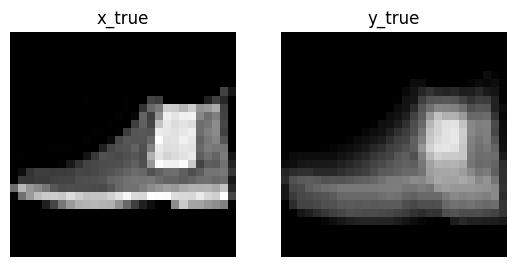

In [ ]:
psf = [[ 0, 1, 0, 0, 0],
       [ 0, 0, 1, 0, 0],
       [ 0, 0, 1, 0, 0],
       [ 0, 0, 1, 0, 0],
       [ 0, 0, 0, 1, 0]]

import torch
psf = torch.tensor(psf).expand(1,1,5,5)
psf = psf / psf.sum()
print("Point spread function\n(true filter kernel)\n", psf.numpy())

import torch.nn.functional as F
x_true = torch.tensor(img).unsqueeze(0).unsqueeze(0).float() / 255.0
y_true = F.conv2d(x_true, psf, padding='same')

# (n, channels, height, width)
print("Input: ", x_true.shape)
print("Output:", y_true.shape)

plt.subplot(1,2,1); plt.axis('off'); plt.title('x_true')
plt.imshow(x_true[0,0].detach(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,2,2); plt.axis('off'); plt.title('y_true')
plt.imshow(y_true[0,0], cmap='gray', vmin=0, vmax=1)
plt.show()

元画像 `x_true` とボケ画像 `y_true` が与えられたとき，PSFを推定できるでしょうか．入力と同じサイズのボケ画像を作るモデルは畳み込み層で表せます．
```python
model = nn.Conv2d(1, 1, 5, bias=False, padding='same')
```
PSFの推定は，このモデルを用いた回帰に他なりません．出力画像 `y_out = model(x_true)` とボケ画像 `y_true` を比べた平均二乗誤差が最小になるように，モデル変数を最適化しましょう．モデル変数は畳み込み層のフィルタカーネルで，PSFを表す $5\times 5$ の配列です．この例では，Adamで千回程度モデル変数を修正すると収束し，CPUでも約1秒の計算時間で正解のPSFと同じフィルタカーネルが得られます．

epoch = 0 , loss =  0.05622463300824165
epoch = 200 , loss =  3.5494929761625826e-05
epoch = 400 , loss =  5.0798794291040394e-06
epoch = 600 , loss =  1.3048808114035637e-06
epoch = 800 , loss =  3.1916715670377016e-07
epoch = 1000 , loss =  6.593812429400714e-08
epoch = 1200 , loss =  1.1075212746902707e-08
epoch = 1400 , loss =  1.4455180386008237e-09
epoch = 1600 , loss =  1.4065675013608114e-10
epoch = 1800 , loss =  9.847131790530206e-12
epoch = 2000 , loss =  4.803645003471912e-13
1.8207676410675049 seconds.
[[[[ 0.   0.2  0.  -0.   0. ]
   [-0.   0.   0.2  0.  -0. ]
   [ 0.  -0.   0.2 -0.   0. ]
   [-0.   0.   0.2  0.  -0. ]
   [ 0.  -0.   0.   0.2  0. ]]]]


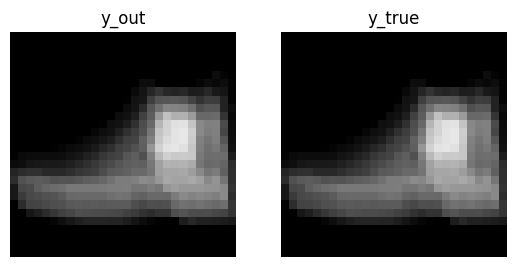

In [ ]:
import torch.nn as nn
model = nn.Conv2d(1, 1, 5, bias=False, padding='same')
optim = torch.optim.Adam(model.parameters(), lr=0.03)
loss = nn.MSELoss()

from time import time
t = time()

for epoch in range(2001):
    y_out = model(x_true)
    mse = loss(y_out, y_true)
    l = mse
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 200 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

print(time()-t, "seconds.")
print(model.weight.detach().numpy().round(3))

plt.subplot(1,2,1); plt.axis('off'); plt.title('y_out')
plt.imshow(y_out[0,0].detach(), cmap='gray', vmin=0, vmax=1)
plt.subplot(1,2,2); plt.axis('off'); plt.title('y_true')
plt.imshow(y_true[0,0], cmap='gray', vmin=0, vmax=1)
plt.show()

では，出力のボケ画像 `y_true` とモデル `model` が与えられたとき，ボケる前の元画像 `x_true` を推定できるでしょうか．推定した元画像 `x_pred` をモデルに入力したときの出力画像 `y_out = model(x_pred)` は，与えられたボケ画像 `y_true` と同じになるべきです．

元画像の推定値 `x_pred` を学習可能な変数とし，平均二乗誤差 `MSELoss(y_out, y_true)` を最小にする `x_pred` を `Adam` で計算します．`x_pred` の初期値は，`x_true` と同じサイズですべての画素値がゼロの黒画像とします．

epoch = 0 , loss =  0.0777144506573677
epoch = 500 , loss =  1.8195594748249277e-05
epoch = 1000 , loss =  3.7594438708765665e-06
epoch = 1500 , loss =  1.7049212601705221e-06
epoch = 2000 , loss =  1.0046327361123986e-06
Relative error = 52.0 %


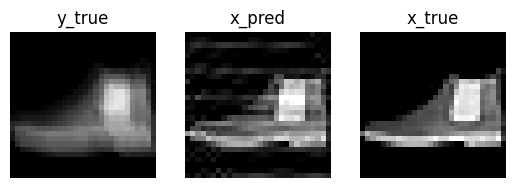

In [ ]:
x_pred = torch.zeros_like(x_true, requires_grad=True)
#x_pred = torch.tensor(y_out, requires_grad=True)   # try another initial x_pred
optim = torch.optim.Adam([x_pred], lr=0.01)
loss = nn.MSELoss()

for epoch in range(2001):
    y_out = model(x_pred)
    l = loss(y_out, y_true)
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 500 == 0:
        print("epoch =", epoch, ", loss = ", l.item())

print("Relative error =", ((x_pred.detach()-x_true).abs().sum() / x_true.abs().sum() * 100).round().item(), "%")

plt.subplot(1,3,1); plt.axis('off'); plt.title('y_true')
plt.imshow(y_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(1,3,2); plt.axis('off'); plt.title('x_pred')
plt.imshow(x_pred[0,0].detach(), cmap='gray', vmin=0, vmax=1)

plt.subplot(1,3,3); plt.axis('off'); plt.title('x_true')
plt.imshow(x_true[0,0], cmap='gray', vmin=0, vmax=1)
plt.show()

実は，この平均二乗誤差 `MSELoss(y_out, y_true)` の最小解はひとつに定まりません．推定結果の `x_pred` は初期値に依存します．推定結果の `x_pred` がもつ不自然な模様は，`model` に入力するとボケて消えます．ボケて消えるような模様は無数に考えられますが，そのような模様の有無を `y_true` から推定できません．

最小解が一意になるように，条件を付加しましょう．元画像は，濃淡の変化が少ない平坦な領域が組み合わさっていると仮定します．物体の輪郭のように濃淡が急激に変化する画素は少ないはずです．そのような画素は，画像の勾配の大きさで観察できます．推定結果の勾配強度（gradient magnitude） `gradmag(x_pred)` を元画像の勾配強度 `gradmag(x_true)` と比べてみましょう．不自然な模様による勾配強度が目立ちますね．

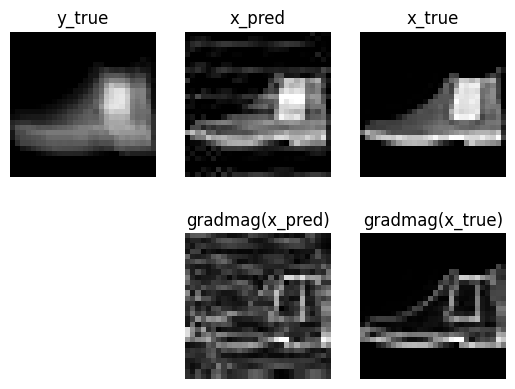

In [ ]:
gradmag2 = (lambda x: F.pad(torch.diff(x, dim=-1), pad=(0,1,0,0), mode='replicate').square()
                    + F.pad(torch.diff(x, dim=-2), pad=(0,0,0,1), mode='replicate').square())

plt.subplot(2,3,1); plt.axis('off'); plt.title('y_true')
plt.imshow(y_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(2,3,2); plt.axis('off'); plt.title('x_pred')
plt.imshow(x_pred[0,0].detach(), cmap='gray', vmin=0, vmax=1)

plt.subplot(2,3,3); plt.axis('off'); plt.title('x_true')
plt.imshow(x_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(2,3,5); plt.axis('off'); plt.title('gradmag(x_pred)')
plt.imshow(gradmag2(x_pred)[0,0].detach().sqrt(), cmap='gray', vmin=0)

plt.subplot(2,3,6); plt.axis('off'); plt.title('gradmag(x_true)')
plt.imshow(gradmag2(x_true)[0,0].sqrt(), cmap='gray', vmin=0)
plt.show()

勾配強度の総和を全変動（total variation; TV）といいます．`MSELoss(y_out, y_true)` と `x_pred` の全変動の両者の重み付き和を損失関数とし，その最小解 `x_predTV` をAdamで計算します．不自然な模様は抑制され，`gradmag(x_predTV)` も正解に近い最小解が得られることを確認できます．

epoch = 0 , loss =  0.0777144506573677 , mse = 0.0777144506573677 , tv = 1.000000082740371e-09
epoch = 500 , loss =  0.0001336071582045406 , mse = 2.8715658118017018e-05 , tv = 0.00010489150008652359
epoch = 1000 , loss =  0.0001035947134369053 , mse = 7.717280823271722e-06 , tv = 9.587743261363357e-05
epoch = 1500 , loss =  9.81536359176971e-05 , mse = 4.102497769054025e-06 , tv = 9.405113814864308e-05
epoch = 2000 , loss =  9.700477676233277e-05 , mse = 3.0655257887701737e-06 , tv = 9.393924847245216e-05
Relative error = 4.0 %


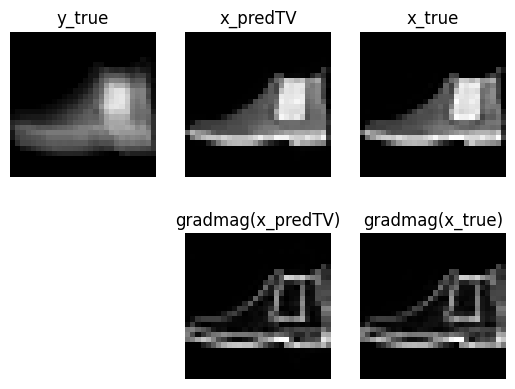

In [ ]:
x_predTV = torch.zeros_like(x_true, requires_grad=True)
optim = torch.optim.Adam([x_predTV], lr=0.01)

loss = nn.MSELoss()
tvloss = lambda x: (gradmag2(x)+1e-12).sqrt().mean() # gradient of sqrt() is nan at 0
lambda_tv = 1e-3

for epoch in range(2001):
    y_out = model(x_predTV)
    mse = loss(y_out, y_true)
    tv = lambda_tv * tvloss(x_predTV)
    l = mse + tv
    optim.zero_grad()
    l.backward()
    optim.step()
    if epoch % 500 == 0:
        print("epoch =", epoch, ", loss = ", l.item(), ", mse =", mse.item(), ", tv =", tv.item())

print("Relative error =", ((x_predTV.detach()-x_true).abs().sum() / x_true.abs().sum() * 100).round().item(), "%")

plt.subplot(2,3,1); plt.axis('off'); plt.title('y_true')
plt.imshow(y_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(2,3,2); plt.axis('off'); plt.title('x_predTV')
plt.imshow(x_predTV[0,0].detach(), cmap='gray', vmin=0, vmax=1)

plt.subplot(2,3,3); plt.axis('off'); plt.title('x_true')
plt.imshow(x_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(2,3,5); plt.axis('off'); plt.title('gradmag(x_predTV)')
plt.imshow(gradmag2(x_predTV)[0,0].detach().sqrt(), cmap='gray')

plt.subplot(2,3,6); plt.axis('off'); plt.title('gradmag(x_true)')
plt.imshow(gradmag2(x_true)[0,0].sqrt(), cmap='gray')
plt.show()

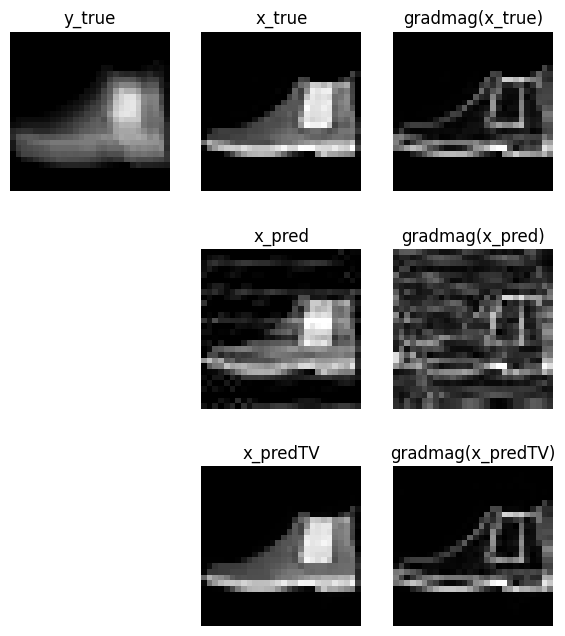

In [ ]:
#@title 画像を再掲します．全変動の有無を見比べて効果を確認してください．
plt.figure(figsize=(7,8))
plt.subplot(3,3,1); plt.axis('off'); plt.title('y_true')
plt.imshow(y_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(3,3,2); plt.axis('off'); plt.title('x_true')
plt.imshow(x_true[0,0], cmap='gray', vmin=0, vmax=1)

plt.subplot(3,3,3); plt.axis('off'); plt.title('gradmag(x_true)')
plt.imshow(gradmag2(x_true)[0,0].sqrt(), cmap='gray', vmin=0)

plt.subplot(3,3,5); plt.axis('off'); plt.title('x_pred')
plt.imshow(x_pred[0,0].detach(), cmap='gray', vmin=0, vmax=1)

plt.subplot(3,3,6); plt.axis('off'); plt.title('gradmag(x_pred)')
plt.imshow(gradmag2(x_pred)[0,0].detach().sqrt(), cmap='gray', vmin=0)

plt.subplot(3,3,8); plt.axis('off'); plt.title('x_predTV')
plt.imshow(x_predTV[0,0].detach(), cmap='gray', vmin=0, vmax=1)

plt.subplot(3,3,9); plt.axis('off'); plt.title('gradmag(x_predTV)')
plt.imshow(gradmag2(x_predTV)[0,0].detach().sqrt(), cmap='gray')
plt.show()

原因 $\vec x$ から結果 $\vec y$ を計算するシミュレータ $f(\vec x)$ を微分可能プログラミングで実装すれば，原因 $\vec x$ と結果 $\vec y$ の組を学習データとしてシミュレータのモデル変数を最適化できます（例：画像をぼかすシミュレータのPSFを推定する）．また，結果 $\vec y$ とシミュレータから，情報を補いつつ最適な原因 $\vec x$ を推定することができます（例：全変動が小さい元画像をボケ画像から推定する）．結果から原因を推定する問題は逆問題（inverse problem）と呼ばれます．つまり，微分可能プログラミングで逆問題を解くために誤差逆伝播法を使えるということです．[SIRモデルのシミュレータを微分可能にして感染拡大・収束の原因を推定](https://arxiv.org/abs/2008.00646)したり，[CGのレンダリングを微分可能にして写真からシーンの3次元情報を得る技術](https://arxiv.org/abs/2006.12057)が台頭しています．また，本稿では解説しませんが，原因 $\vec x$ と結果 $\vec y$ の組がたくさんあれば，シミュレータ $f$ を近似するモデルや，結果 $\vec y$ から原因を予測するモデル，すなわち順問題や逆問題の解法を深層学習で作るというアプローチが考えられます．前者は[代理モデル（surrogate modelまたはmeta model）](https://en.wikipedia.org/wiki/Surrogate_model)と呼ばれます．画像中の物体を推定する画像認識は後者の代表例に過ぎません．

## おわりに

深層学習技術の発展を背景に開発が進んだ微分可能プログラミングは，ニューラルネットワークを前提とした機械学習にとって不可欠です．しかし，本稿で紹介した[PyTorch](https://pytorch.org/)や，[TensorFlow](https://www.tensorflow.org/)，[JAX](https://github.com/google/jax)などは，深層学習専用のフレームワークではなく，自動微分の機能を備えた強力な数値計算のライブラリです．[NumPy](https://numpy.org/)とほとんど同じ使い勝手で，初等関数，FFT，特異値分解など，CPUとGPUで実行できる実に様々な関数が導関数と共に提供されています．また，アルゴリズムを設計・実装せずにモデル変数の最適化を試みることができます．オプティマイザの能力を発揮させられるか，良好な解が得られるかなどは，もちろん問題に依存しますが，アルゴリズムの設計的な限界を超える様々な価値が見出され，科学技術分野に広く波及することは間違いないでしょう．

その他の資料
- 酒井智弥（長崎大学）：
    - [画像の深層学習入門](https://tsakailab.github.io/alpp/READMEja.html)，パターン処理工学特論，2021．
    - [パターン認識と機械学習演習](https://tsakailab.github.io/prml/)，長崎大学情報データ科学部 授業資料，2022．
    - [高次元データ科学とスパースモデリング](https://tsakailab.github.io/HDsci-SpM/)，酒井研究室基礎勉強会資料，2016．

In [ ]:
from jax import grad

In [ ]:
from autograd import grad